In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import keras

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets  as tfds
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import plot_model, to_categorical
from keras import backend as K
!pip install keras-lookahead

  Created wheel for keras-lookahead: filename=keras_lookahead-0.9.0-cp36-none-any.whl size=6406 sha256=a5f05090d9ab9a5c55d86a4c881ab07b24b737c851f51db3bd6f7d8084f9d9da
  Stored in directory: /root/.cache/pip/wheels/80/e1/a7/027d1227307b7425941fe5b1a896f8a8b9556b432a2c540a07
Successfully built keras-lookahead


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
keras.__version__

'2.4.0'

In [6]:
cols = ['EventDescription','FailedAssets','IncidentCause','IncidentConsequence','IncidentType','WeatherStation','Status','Category']

In [7]:
df2 = pd.read_csv('/content/drive/MyDrive/ESV Data/cleaned_incidents1.csv', usecols = cols)
df2.head()

,EventDescription,FailedAssets,IncidentCause,IncidentConsequence,IncidentType,Status,WeatherStation,Category
0,A nearby customer reported sparking of electri...,Conductor (ABC),HVABC cable faulted midspan,Grassfire,Infrastructure (network-based),Report,Avalon Airport,OH Cable
1,A contractor reported that he had contacted an...,No failed asset,Contractor contacted earthing conductor,No Go Zone (contact),Infrastructure (network-based),Report,Laverton Raaf,Dug up
2,A field crew attending an outage found that a ...,Conductor (bare),Conductor broke due to rust,Serious risk to public safety (e.g. live condu...,Infrastructure (network-based),Report,Warrnambool Airport Ndb,Connection
3,Interfere and vandalism in substation. Unknown...,Indoor,Vandalism,Loss of supply;Damage to network assets,Infrastructure (network-based),Report,Essendon Airport,Other
4,A nearby customer reported that a high load ha...,Service conductor,Unknown high load contacted LV service cable,No Go Zone (contact);Damage to network assets,Infrastructure (network-based),Report,Avalon Airport,Vehicle


In [9]:
df2['Category'].unique()

array(['OH Cable', 'Dug up', 'Connection', 'Other', 'Vehicle', 'Fuse',
       'Trees', 'Pole', 'Crossarm', 'Conductor', 'Animal', 'AF Other',
       'Lightning', 'UG Cable', nan, 'Installation'], dtype=object)

In [10]:
df2 = df2.dropna()
df2['Category'].unique()

array(['OH Cable', 'Dug up', 'Connection', 'Other', 'Vehicle', 'Fuse',
       'Trees', 'Pole', 'Crossarm', 'Conductor', 'Animal', 'AF Other',
       'Lightning', 'UG Cable', 'Installation'], dtype=object)

In [11]:
df2.shape
df2.isnull().sum()

EventDescription       0
FailedAssets           0
IncidentCause          0
IncidentConsequence    0
IncidentType           0
Status                 0
WeatherStation         0
Category               0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

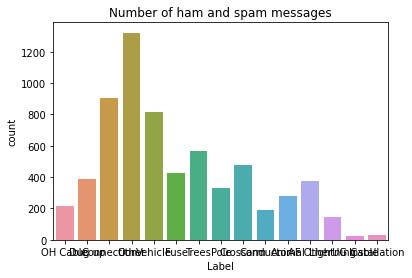

In [13]:
sns.countplot(df2.Category)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [157]:
# Old models
# '''
# def RNN():
#     inputs = Input(name='inputs',shape=[max_len])
#     layer = Embedding(max_words,100,input_length=max_len)(inputs)
#     layer = LSTM(64)(layer)
#     layer = Dense(128,name='FC1')(layer)
#     layer = Activation('relu')(layer)
#     layer = Dropout(0.2)(layer)

#     lyer = Dense(128,name='FC2')(layer)
#     layer = Activation('relu')(layer)
#     layer = Dropout(0.2)(layer)


#     layer = Dense(16,name='out_layer')(layer)
#     layer = Activation('softmax')(layer)
#     model = Model(inputs=inputs,outputs=layer)
#     return model

# def RNN2():
#     # model = keras.Sequential()

#     # model.add(
#     #     layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
#     # )
#     # model.add(layers.Bidirectional(layers.LSTM(32)))
#     # model.add(layers.Dense(10))

#     # #model.summary()
#     model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(max_words, 64),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(16)
#     ])
#     return model
# '''



In [14]:
df2['Description'] = df2['WeatherStation'] + ' ' + df2['IncidentType'] + ' ' + df2['Status'] + ' ' + df2['EventDescription'] + ' ' + df2['FailedAssets'] + ' ' + df2['IncidentCause']+ ' ' + df2['IncidentConsequence']

In [15]:
df2['Description']

0       Avalon Airport Infrastructure (network-based) ...
1       Laverton Raaf Infrastructure (network-based) R...
2       Warrnambool Airport Ndb Infrastructure (networ...
3       Essendon Airport Infrastructure (network-based...
4       Avalon Airport Infrastructure (network-based) ...
                              ...                        
6499    Moorabbin Airport Infrastructure (network-base...
6500    Avalon Airport Infrastructure (network-based) ...
6501    Mildura Airport Infrastructure (network-based)...
6502    Swan Hill Aerodrome Infrastructure (network-ba...
6503    Moorabbin Airport Infrastructure (network-base...
Name: Description, Length: 6488, dtype: object

In [18]:
#Preprocessing df.EventDescription
import nltk 
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df2['Description'] = df2['Description'].apply(clean_text)


'''

def getLemmText(text):
 tokens=word_tokenize(text)
 lemmatizer = WordNetLemmatizer()
 tokens=[lemmatizer.lemmatize(word) for word in tokens]
 return ' '.join(tokens)
df['EventDescription'] = list(map(getLemmText,df['EventDescription']))
df['FailedAssets'] = list(map(getLemmText,df['FailedAssets']))
df['IncidentCause'] = list(map(getLemmText,df['IncidentCause']))
df['IncidentConsequence'] = list(map(getLemmText,df['IncidentConsequence']))
#df['IncidentType'] = list(map(getLemmText,df['IncidentType']))

df.head()

def getStemmText(text):
    tokens=word_tokenize(text)
    ps = PorterStemmer()
    tokens=[ps.stem(word) for word in tokens]
    return ' '.join(tokens)
df['EventDescription'] = list(map(getStemmText,df['EventDescription']))
df['FailedAssets'] = list(map(getStemmText,df['FailedAssets']))
df['IncidentCause'] = list(map(getStemmText,df['IncidentCause']))
df['IncidentConsequence'] = list(map(getStemmText,df['IncidentConsequence']))
#df['IncidentType'] = list(map(getStemmText,df['IncidentType']))
'''
df2.head()
print(df2.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
(6488, 9)


In [20]:
df2.Description

0       avalon airport infrastructure networkbased rep...
1       laverton raaf infrastructure networkbased repo...
2       warrnambool airport ndb infrastructure network...
3       essendon airport infrastructure networkbased r...
4       avalon airport infrastructure networkbased rep...
                              ...                        
6499    moorabbin airport infrastructure networkbased ...
6500    avalon airport infrastructure networkbased rep...
6501    mildura airport infrastructure networkbased re...
6502    swan hill aerodrome infrastructure networkbase...
6503    moorabbin airport infrastructure networkbased ...
Name: Description, Length: 6488, dtype: object

In [24]:
#Label encode the category
le = LabelEncoder()
df2['Category'] = le.fit_transform(df2['Category'].astype(str))
Y = df2['Category'] 

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df2['Description'],Y, 
                                                    test_size=0.3, random_state=1)

In [26]:
max_words = 1000*5
max_len = 100*1
tok = Tokenizer(num_words=max_words,filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True, split=" ",)
tok.fit_on_texts(df2['Description'])
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) #X_train
print(sequences_matrix.shape)

(4541, 100)


In [31]:
sequences1 = tok.texts_to_sequences(x_test)
sequences_matrix1 = sequence.pad_sequences(sequences1,maxlen=max_len) #X_train
print(sequences_matrix1.shape)

(1947, 100)


In [36]:
units_mul = 200
unique_categories = np.unique(Y)
print(unique_categories)
labels_count = len(unique_categories)
dropout = 0.2

def RNN3():
  model = tf.keras.Sequential()
  # model.add(Embedding(max_words, units_mul, input_length=sequences_matrix.shape[1]))
  # # model.add(layers.SpatialDropout1D(0.2))
  # model.add(layers.Bidirectional(layers.LSTM(units_mul, return_sequences=True, dropout=0.2)))
  # # model.add(layers.Bidirectional(layers.LSTM(units_mul, dropout=0.2, recurrent_dropout=0.2)))

  # #model.add(tf.keras.layers.SpatialDropout1D(0.2))
  # #model.add(LSTM(units_mul, dropout=0.2, recurrent_dropout=0.2))

  # model.add(layers.Bidirectional(LSTM(units_mul, return_sequences=True)))
  # model.add(layers.Bidirectional(LSTM(units_mul)))

  # model.add(Dense(units_mul, activation='relu'))
  # model.add(Dropout(0.2))
  # model.add(Dense(units_mul, activation='softmax'))
  # model.add(Dropout(0.2))

  # try1: return_sequences=True => 74
  # try2: try convo2d
  # try3: recurrent_activation = relu/softmax in LSTM
  # try4: 2 Bi Directional LSTM layers

  model.add(Embedding(max_words, units_mul, input_length=sequences_matrix.shape[1]))
  model.add(tf.keras.layers.SpatialDropout1D(0.2))
  model.add(layers.Conv1D(units_mul,3,padding='valid',activation='relu',strides=1))
  #model.add(layers.Conv1D(units_mul,3,padding='valid',activation='relu',strides=1))
  model.add(layers.MaxPooling1D(pool_size=2))
  # todo try bidrectional layer again
  model.add(layers.Bidirectional(LSTM(units_mul, dropout=dropout,recurrent_dropout=dropout)))
  # model.add(LSTM(units_mul, dropout=dropout, recurrent_dropout=dropout))
  # todo use GRU layer
  #model.add(GRU(10))
  #model.add(Dropout(dropout))

  # model.add(keras.layers.Dense(units=1000, activation='relu'))
  # model.add(keras.layers.Dense(units=500, activation='relu'))
    
  # model.add(Dense(units_mul, activation='relu'))
  # model.add(Dropout(dropout))
  
  model.add(Dense(labels_count, activation='softmax'))
  return model

RNN3().summary()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 200)          1000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 200)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 98, 200)           120200    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 49, 200)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 400)               641600    
_________________________________________________________________
dense_4 (Dense)              (None, 15)                6015      
Total params: 1,767,815
Trainable params: 1,767,815
Non-trainable params:

In [37]:
from keras_lookahead import Lookahead
from keras.callbacks import LearningRateScheduler
optimiser = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
lk = Lookahead(optimiser, sync_period=5, slow_step=0.5, name = 'Lookahead')

#The step decay learning rate
#Step Decay A typical way is to to drop the learning rate by half every 10 epochs 
#https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

def step_decay(epoch):
    initAlpha = 0.01
    factor = 0.25
    dropEvery = 5
    alpha = initAlpha *(factor **np.floor((1 + epoch)/dropEvery))
    return float(alpha)


# train model
model = RNN3()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=lk.optimizer,
              metrics=['accuracy'])
with tf.device('/device:GPU:0'):
  history = model.fit(sequences_matrix,y_train, batch_size=128,
                    epochs=20, 
                    validation_split=0.2,
                    callbacks=[LearningRateScheduler(step_decay)])


Epoch 1/20
29/29 [==============================] - 12s 404ms/step - loss: 1.5543 - accuracy: 0.5110 - val_loss: 0.8701 - val_accuracy: 0.7360
Epoch 2/20
29/29 [==============================] - 11s 385ms/step - loss: 0.6974 - accuracy: 0.7907 - val_loss: 0.7778 - val_accuracy: 0.7602
Epoch 3/20
29/29 [==============================] - 11s 373ms/step - loss: 0.4483 - accuracy: 0.8654 - val_loss: 0.8734 - val_accuracy: 0.7602
Epoch 4/20
29/29 [==============================] - 11s 394ms/step - loss: 0.2877 - accuracy: 0.9141 - val_loss: 0.8791 - val_accuracy: 0.7646
Epoch 5/20
29/29 [==============================] - 10s 359ms/step - loss: 0.1635 - accuracy: 0.9513 - val_loss: 0.8266 - val_accuracy: 0.7921
Epoch 6/20
29/29 [==============================] - 11s 387ms/step - loss: 0.0937 - accuracy: 0.9760 - val_loss: 0.8398 - val_accuracy: 0.7987
Epoch 7/20
29/29 [==============================] - 12s 400ms/step - loss: 0.0730 - accuracy: 0.9829 - val_loss: 0.8768 - val_accuracy: 0.7954

In [38]:
accr = model.evaluate(sequences_matrix1,y_test)
print(accr[1])

61/61 [==============================] - 2s 27ms/step - loss: 0.9048 - accuracy: 0.8084
0.8084232211112976


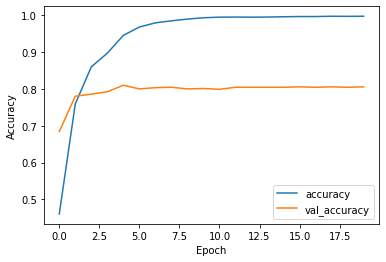

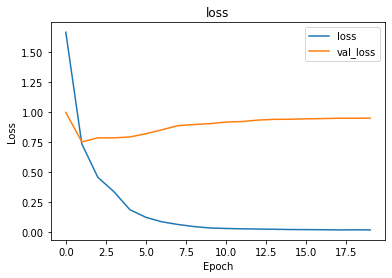

In [33]:
# Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [174]:
#Save the model.

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
with open("model_num.json", "w") as json_file:
  json_file.write('model_json')
model.save_weights('model_weights.h5')
